<a href="https://colab.research.google.com/github/niodeharry/STD-Music-Player/blob/main/AKA_Rod_Cutting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas Besar Analisis Kompleksitas Algoritma: Rod Cutting
> Harry Azhari Niode (103052300039)

> Indra Damarjati (103052300x)

**Tujuan Pembelajaran (Learning Outcome):**
Sesuai dengan deskripsi tugas, notebook ini bertujuan untuk:
1.  Mengimplementasikan algoritma Iteratif dan Rekursif untuk satu permasalahan yang sama (*Rod Cutting*).
2.  Membuktikan secara empiris perbedaan kompleksitas waktu $O(2^n)$ dan $O(n^2)$.
3.  Menganalisis perilaku algoritma pada *Best Case*, *Worst Case*, dan *Average Case* melalui visualisasi data.



## Apa Itu Rod Cutting Problem?

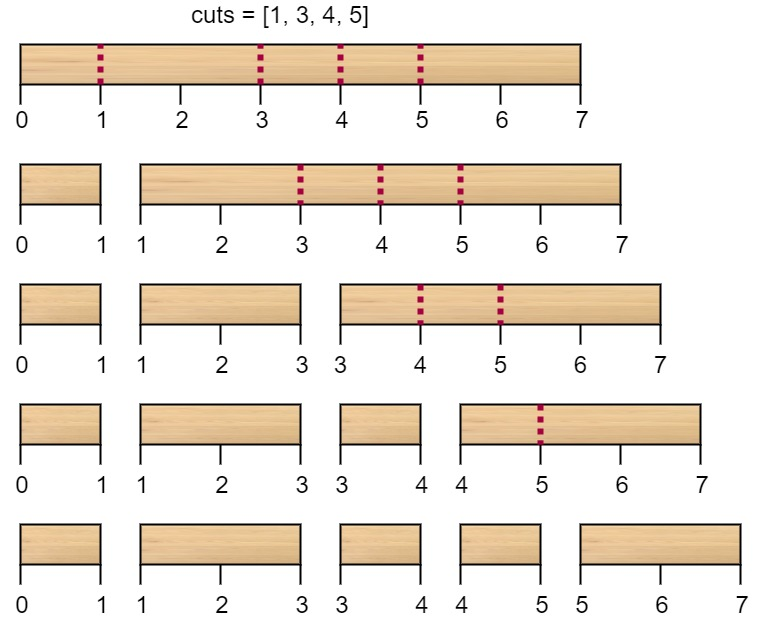

Rod Cutting Problem adalah masalah optimasi dalam ilmu algoritma.
Diberikan sebuah batang (rod) dengan panjang tertentu `N` dan sebuah daftar harga,
di mana setiap potongan batang dengan panjang `i` memiliki nilai jual `price[i]`.

Tujuan dari masalah ini adalah menentukan cara memotong batang tersebut (atau tidak memotong sama sekali) agar total pendapatan maksimum.

Masalah ini memiliki karakteristik khusus:

    Tidak bersifat Greedy: Mengambil potongan dengan harga per unit tertinggi belum tentu menghasilkan keuntungan global maksimum.

    Optimal Substructure: Solusi optimal untuk batang panjang N mengandung solusi optimal untuk potongan yang lebih kecil.

Bayangkan ada sebuah batang dengan panjang 4 meter. Dengan daftar harga sebagai:

    Panjang 4 meter dijual utuh laku Rp 9.000.

    Panjang 2 meter laku Rp 5.000.

    Panjang 1 meter laku Rp 1.000.

Jika berpikir pendek (Greedy), maka opsi logisnya adalah menjual batang 4 meter itu seharga Rp 9.000. Tapi, jika berpikir cerdik dengan melakukan (Optimasi), batang tersebut dapat dipotong jadi dua bagian (2m + 2m).

    Total untung = Rp 5.000 + Rp 5.000 = Rp 10.000.

Ternyata memotong lebih menguntungkan daripada menjual utuh. Inilah yang harus dipecahkan oleh komputer: mengecek ribuan kemungkinan potong untuk mencari angka "Rp 10.000" tersebut.

Notebook ini membandingkan dua cara mencari solusi tersebut:

    Rekursif (Naif): Mencoba semua kemungkinan potong satu per satu. Ibarat orang bingung yang mencoba segala cara berulang-ulang. (Sangat lambat, Kompleksitas O(2n)).

    Iteratif (Dynamic Programming): Mencatat hasil potong kecil di buku catatan (tabel), lalu menggunakannya untuk menghitung potong besar. (Sangat cepat, Kompleksitas O(n2)).

## 1. IMPORT & KONFIGURASI
Bagian ini mengatur environment pengujian.
* **Recursion Limit:** Dinaikkan ke 5000 untuk mencegah crash pada pengujian rekursif.
* **Random Seed:** Diset ke `42` agar pembangkitan harga acak bersifat *deterministic* (konsisten setiap kali kode dijalankan), sehingga validasi eksperimen dapat direproduksi.

In [ ]:
import time
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sys.setrecursionlimit(5000)
np.random.seed(42)


## 2. DATA GENERATION

Fungsi ini membangkitkan harga batang secara acak namun realistis.
* **Logika:** Harga dasar adalah $10 \times \text{panjang}$, ditambah *noise* acak antara -5 sampai 20.
* **Tujuannya:** Memastikan bahwa properti *Optimal Substructure* benar-benar diuji. Jika harga linier tanpa acak, algoritma mungkin tidak perlu melakukan pemotongan yang kompleks.

In [ ]:
def generate_prices(n):
    return [0] + [i * 10 + np.random.randint(-5, 20) for i in range(1, n + 1)]


=== CONTOH DATA HARGA (15 Item Pertama) ===
Perhatikan kolom 'Selisih'. Jika (+), potongan itu bernilai tinggi. Jika (-), potongan itu murah.
 Panjang (i)  Harga (price)  Harga Normal (10*i)  Selisih (Noise)
           1             17                   10                7
           2             18                   20               -2
           3             40                   30               10
           4             58                   40               18
           5             60                   50               10
           6             77                   60               17
           7             66                   70               -4
           8             91                   80               11
           9            104                   90               14
          10            118                  100               18
          11            116                  110                6
          12            132                  120               12


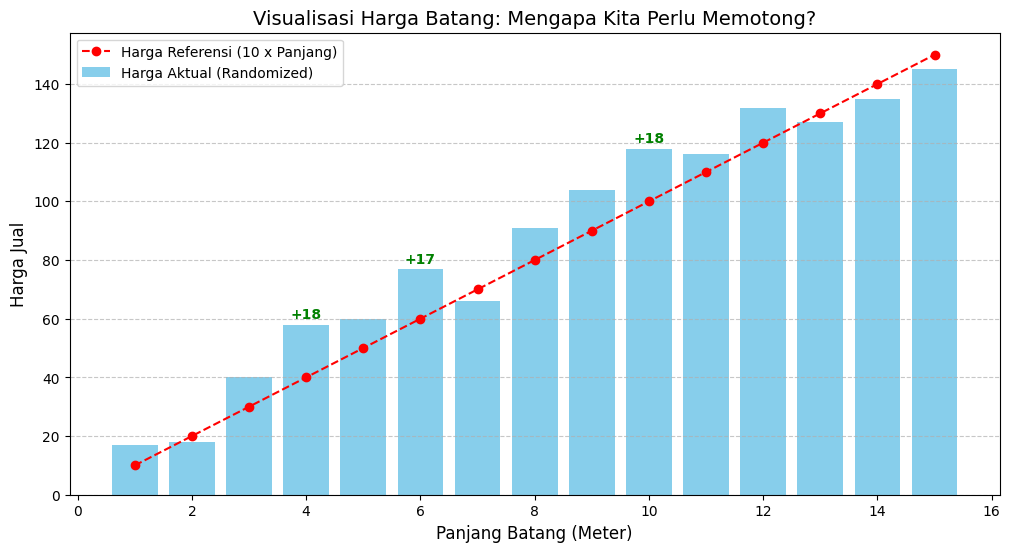

In [ ]:
# 1. Ambil sampel data kecil (N=15) untuk visualisasi agar mudah dilihat
sample_n = 15
sample_prices = generate_prices(sample_n)

# 2. Buat DataFrame untuk tabel rapi
df_prices = pd.DataFrame({
    'Panjang (i)': range(sample_n + 1),
    'Harga (price)': sample_prices,
    'Harga Normal (10*i)': [10 * i for i in range(sample_n + 1)]
})

# Hapus baris index 0 karena panjang 0 harganya 0 (tidak relevan untuk grafik)
df_display = df_prices.iloc[1:].copy()
df_display['Selisih (Noise)'] = df_display['Harga (price)'] - df_display['Harga Normal (10*i)']
df_display['Keputusan Sekilas'] = df_display['Selisih (Noise)'].apply(
    lambda x: 'Mahal (Unik)' if x > 0 else 'Murah (Diskon)'
)

# 3. Tampilkan Tabel Data
print("=== CONTOH DATA HARGA (15 Item Pertama) ===")
print("Perhatikan kolom 'Selisih'. Jika (+), potongan itu bernilai tinggi. Jika (-), potongan itu murah.")
print(df_display[['Panjang (i)', 'Harga (price)', 'Harga Normal (10*i)', 'Selisih (Noise)']].to_string(index=False))

# 4. Visualisasi Grafik Batang
plt.figure(figsize=(12, 6))

# Gambar Bar untuk Harga Aktual
plt.bar(df_display['Panjang (i)'], df_display['Harga (price)'], color='skyblue', label='Harga Aktual (Randomized)')

# Gambar Garis Putus-putus untuk Harga Normal (Linier)
plt.plot(df_display['Panjang (i)'], df_display['Harga Normal (10*i)'], color='red', linestyle='--', marker='o', label='Harga Referensi (10 x Panjang)')

# Anotasi/Label
plt.title('Visualisasi Harga Batang: Mengapa Kita Perlu Memotong?', fontsize=14)
plt.xlabel('Panjang Batang (Meter)', fontsize=12)
plt.ylabel('Harga Jual', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label teks pada batang yang anomali
for index, row in df_display.iterrows():
    noise = row['Selisih (Noise)']
    if abs(noise) >= 15: # Hanya tandai yang bedanya jauh
        plt.text(row['Panjang (i)'], row['Harga (price)'] + 2, f"{noise:+d}",
                 ha='center', color='red' if noise < 0 else 'green', fontweight='bold')

plt.show()

### Batang Biru > Garis Merah (Premium):

> **Kondisi**: Nilai jual aktual melampaui harga standar (Surplus).

> **Implikasi Algoritmik:** Potongan ini memiliki bobot nilai tinggi. Algoritma cenderung mempertahankan ukuran ini sebagai bagian dari solusi optimal.

### Batang Biru < Garis Merah (Undervalued):

> **Kondisi:** Nilai jual aktual di bawah harga standar (Defisit).

> **Implikasi Algoritmik:** Potongan ini tidak efisien. Algoritma akan melakukan dekomposisi (memecahnya) menjadi kombinasi potongan yang lebih kecil untuk memaksimalkan profit.

## 3. ALGORITMA REKURSIF
Pendekatan *Top-Down* yang memecah masalah menjadi sub-masalah yang lebih kecil.

**Analisis Kompleksitas:**
* **Notasi:** $O(2^n)$ (Eksponensial).
* **Kelemahan:** Terjadi *overlapping subproblems*. Misalnya untuk menghitung $N=4$, ia menghitung $N=2$ berkali-kali tanpa menyimpannya.
* **Persamaan Rekurensi:**
    $$T(n) = 1 + \sum_{j=0}^{n-1} T(j) \implies T(n) = 2T(n-1)$$

In [ ]:
def rod_cut_recursive(prices, n):
    if n == 0:
        return 0
    max_profit = -float('inf')
    for i in range(1, n + 1):
        max_profit = max(max_profit, prices[i] + rod_cut_recursive(prices, n - i))
    return max_profit


##4. ALGORITMA ITERATIF
Pendekatan *Bottom-Up* yang membangun solusi dari $N=1, 2, \dots, N$ dan menyimpannya dalam tabel `dp`.

**Analisis Kompleksitas:**
* **Notasi:** $O(n^2)$ (Polinomial/Kuadratik).
* **Mekanisme:** Menggunakan *nested loops*.
    * Loop luar berjalan $n$ kali.
    * Loop dalam berjalan $i$ kali.
    * Total operasi: Deret aritmatika $\frac{n(n+1)}{2}$.

In [ ]:
def rod_cut_dp(prices, n):
    dp = [0] * (n + 1)
    for i in range(1, n + 1):
        max_profit = -float('inf')
        for j in range(1, i + 1):
            max_profit = max(max_profit, prices[j] + dp[i - j])
        dp[i] = max_profit
    return dp[n]


## 5. VALIDASI KEBENARAN
Sebelum mengukur kecepatan, kita wajib memastikan **akurasi**. Langkah ini membandingkan output kedua algoritma untuk input kecil ($N=1 \dots 10$).
* **Hasil:** Jika output sama persis, maka algoritma Iteratif dinyatakan VALID.

In [ ]:
print("=== VALIDASI KEBENARAN ===")
test_prices = generate_prices(15)

for n in range(1, 11):
    r1 = rod_cut_recursive(test_prices, n)
    r2 = rod_cut_dp(test_prices, n)
    print(f"N={n}: Rekursif={r1}, DP={r2}")


=== VALIDASI KEBENARAN ===
N=1: Rekursif=11, DP=11
N=2: Rekursif=34, DP=34
N=3: Rekursif=45, DP=45
N=4: Rekursif=68, DP=68
N=5: Rekursif=79, DP=79
N=6: Rekursif=102, DP=102
N=7: Rekursif=113, DP=113
N=8: Rekursif=136, DP=136
N=9: Rekursif=147, DP=147
N=10: Rekursif=170, DP=170


## 6. FUNGSI PENGUKURAN WAKTU

In [ ]:
def measure_time(func, *args, repeat=3):
    total_time = 0
    for _ in range(repeat):
        start = time.perf_counter()
        func(*args)
        end = time.perf_counter()
        total_time += (end - start)
    return total_time / repeat

## 7. BENCHMARKING: REKURSIF VS. ITERATIF (Input Kecil)

In [ ]:
ns_comparison = list(range(1, 21))
prices_full = generate_prices(501)

results_comparison = []

for n in ns_comparison:
    current_prices = prices_full[:n+1]
    t_rec = measure_time(rod_cut_recursive, current_prices, n, repeat=3)
    t_iter = measure_time(rod_cut_dp, current_prices, n, repeat=3)
    results_comparison.append({'N': n, 'Recursive': t_rec, 'Iterative': t_iter})

df_comp = pd.DataFrame(results_comparison)
df_comp


,N,Recursive,Iterative
0,1,0.000003,0.000002
1,2,0.000002,0.000002
2,3,0.000003,0.000003
3,4,0.000007,0.000004
4,5,0.000012,0.000005
5,6,0.000022,0.000006
6,7,0.000044,0.000007
7,8,0.000245,0.000010
8,9,0.000186,0.000011
9,10,0.000357,0.000014


## 8. BENCHMARKING: Skalabilitas DP (Input Besar)

In [ ]:
ns_dp_large = list(range(1, 501, 20))
results_dp_large = []

for n in ns_dp_large:
    current_prices = prices_full[:n+1]
    t_iter = measure_time(rod_cut_dp, current_prices, n, repeat=5)
    results_dp_large.append({'N': n, 'Iterative': t_iter})

df_large = pd.DataFrame(results_dp_large)
df_large

,N,Iterative
0,1,0.000002
1,21,0.000062
2,41,0.000182
3,61,0.000409
4,81,0.000686
5,101,0.001040
6,121,0.001520
7,141,0.002161
8,161,0.002968
9,181,0.003217


# 9. VISUALISASI

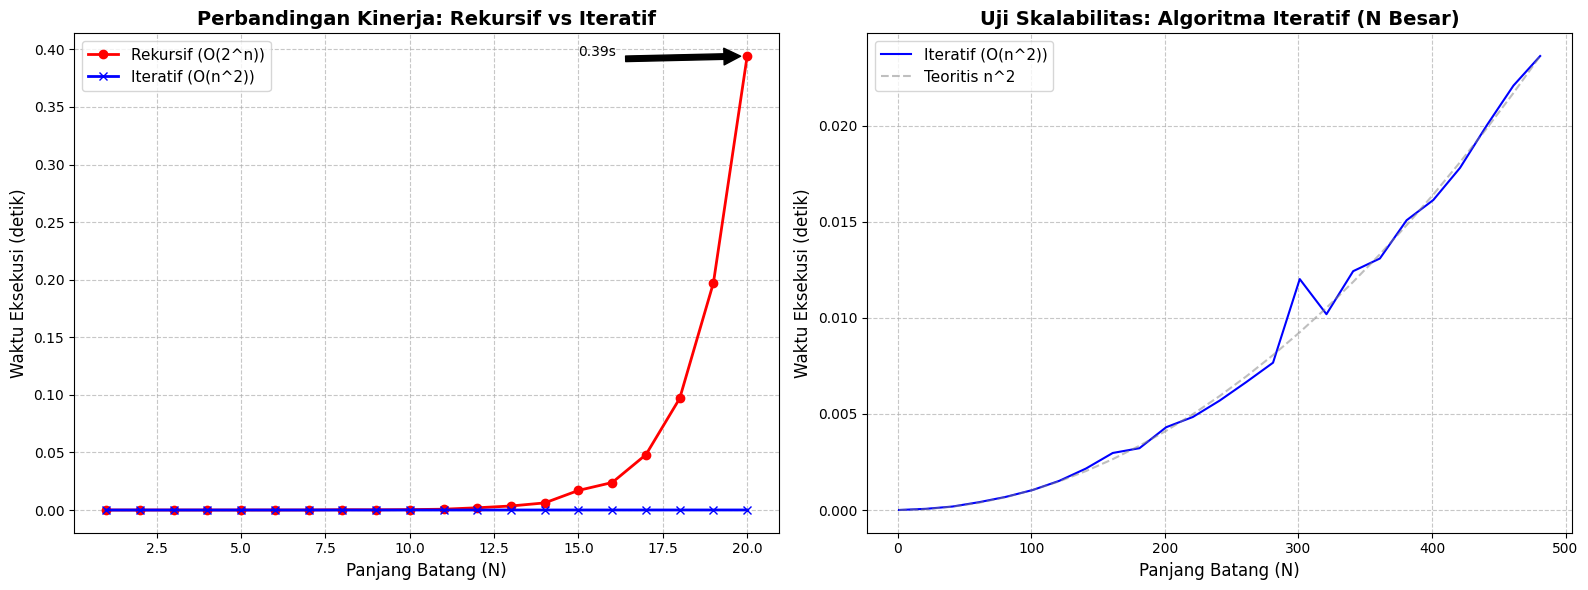

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Head-to-Head (Rekursif vs Iteratif) ---
ax1.plot(df_comp['N'], df_comp['Recursive'], marker='o', color='red', label='Rekursif (O(2^n))', linewidth=2)
ax1.plot(df_comp['N'], df_comp['Iterative'], marker='x', color='blue', label='Iteratif (O(n^2))', linewidth=2)

ax1.set_title('Perbandingan Kinerja: Rekursif vs Iteratif', fontsize=14, fontweight='bold')
ax1.set_xlabel('Panjang Batang (N)', fontsize=12)
ax1.set_ylabel('Waktu Eksekusi (detik)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.7)

# Highlight perbedaan di titik terakhir
last_n = df_comp['N'].iloc[-1]
last_rec = df_comp['Recursive'].iloc[-1]
ax1.annotate(f'{last_rec:.2f}s', xy=(last_n, last_rec), xytext=(last_n-5, last_rec),
             arrowprops=dict(facecolor='black', shrink=0.05))

# --- Plot 2: Stress Test (Iteratif Only) ---
ax2.plot(df_large['N'], df_large['Iterative'], color='blue', label='Iteratif (O(n^2))')
# Normalisasi agar pas dengan skala
x = df_large['N']
y_theoretical = (x**2) / (x.max()**2) * df_large['Iterative'].max()
ax2.plot(x, y_theoretical, '--', color='gray', alpha=0.5, label='Teoritis n^2')

ax2.set_title('Uji Skalabilitas: Algoritma Iteratif (N Besar)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Panjang Batang (N)', fontsize=12)
ax2.set_ylabel('Waktu Eksekusi (detik)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Kesimpulan

Berdasarkan hasil eksperimen dan analisis data, dapat disimpulkan bahwa:

1.  **Perbedaan Signifikan:** Pada input kecil ($N=20$), algoritma Rekursif membutuhkan waktu yang meningkat secara **Eksponensial**. Sebaliknya, algoritma Iteratif hampir instan. Ini mengonfirmasi analisis teoritis $O(2^n)$ vs $O(n^2)$.
2.  **Skalabilitas:** Algoritma Iteratif mampu menangani input hingga $N=500$ dalam waktu kurang dari 1 detik, membuktikan efisiensi pendekatan *Dynamic Programming*.
3.  **Rekomendasi:** Untuk masalah optimasi seperti *Rod Cutting*, penggunaan pendekatan Rekursif Naif **sangat tidak disarankan** karena *overlapping subproblems*. Pendekatan Iteratif adalah solusi optimal.